In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [ ]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [4]:
scenario = 'Hawaii_20201106'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    # era5_smoothing_window=15,
    # denoise = True,
    )

In [5]:
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Hawaii_20201106/40AB_9158_B0E7_B3F4_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


## - Beam footprint lowpass_filter

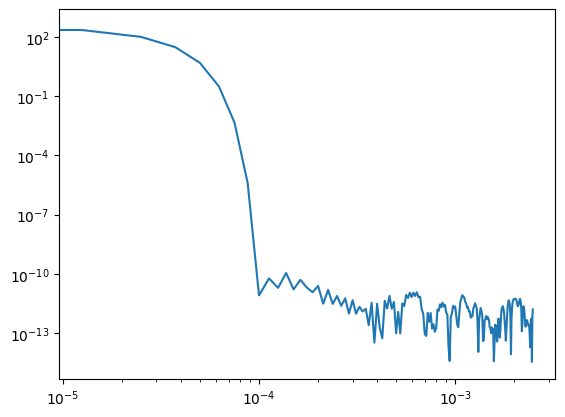

In [9]:
t = test.data['beam'].sel(grg = 600e3, method = 'nearest')

f_min = 1/ t.az_idx.max()
f_max = 1 / (2* np.diff(t.az_idx).mean())
f =  np.arange(0, f_max, f_min)

T = (abs(np.fft.fftshift(np.fft.fft(t)))**2)
plt.loglog(f, T[-f.shape[0]:])

## Frequencies below 10km-1 are filtered

### Spacing between samples should be <= 5km, greater spacings will lose resolution

In [39]:
def RMSE(x):
    return np.sqrt(np.mean(x**2))

In [72]:
A = 8000
B = 100
lower_limit = 0.3  # Replace with your lower limit
upper_limit = 20.0  # Replace with your upper limit
step_size = 0.01  # Adjust the step size as needed
p = 1/step_size
valid_values_of_C = []

# Loop through the range with the specified step size
for C in range(int(lower_limit * p), int(upper_limit * p) + 1, int(step_size * p)):
    C /= p  # Convert back to decimal
    if C != 0 and (A / C) % B == 0:
        valid_values_of_C.append(C)

print("Valid values of C:", valid_values_of_C)


Valid values of C: [0.32, 0.4, 0.5, 0.64, 0.8, 1.0, 1.25, 1.6, 2.0, 2.5, 3.2, 4.0, 5.0, 8.0, 10.0, 16.0, 20.0]


In [73]:

rmses = []
for PRF in valid_values_of_C:
    test4 = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=60_000,
    vx_sat=8000,
    PRF=PRF,
    resolution_spatial=100,
    length_antenna=3.2,
    beam_pattern='phased_array',
    era5_smoothing_window=30
    )

    test4.apply()
    rmse = RMSE(test4.data.V_leakage_pulse_rg_subscene - test4.data.V_leakage_pulse_rg_subscene_inverted).values*1
    rmses.append(rmse)
    

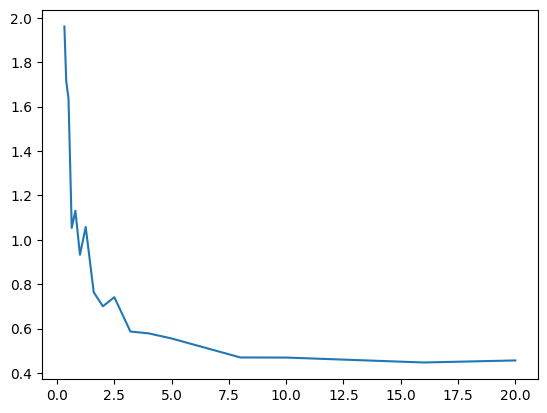

In [77]:
plt.plot(valid_values_of_C, rmses)